# Modulation Classification

## Imports

In [37]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize 
from scipy.integrate import cumtrapz
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
import keras.models as models
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = "/content/drive/MyDrive/Pattern Recognition/Modulation Classification/RML2016.10b.tar.bz2"

## Dowload Dataset

In [4]:
%cp -av "/content/drive/MyDrive/Pattern Recognition/Modulation Classification/RML2016.10b.tar.bz2" "/content/dataset"

'/content/drive/MyDrive/Pattern Recognition/Modulation Classification/RML2016.10b.tar.bz2' -> '/content/dataset/RML2016.10b.tar.bz2'


In [5]:
!tar xjvf "/content/dataset/RML2016.10b.tar.bz2"

RML2016.10b.dat
LICENSE.TXT


In [ ]:
with open("/content/RML2016.10b.dat", 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()

In [6]:
file = open("/content/RML2016.10b.dat",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

## Visualization

In [7]:
def randomVisualization():
  mod = lbl[0][0]
  idx = []
  res = []
  idx.append([0, mod.decode("utf-8"), lbl[0][1]])
  for i in range(len(lbl)):
    if lbl[i][0] == mod:
      continue
    idx.append([i-1, mod.decode("utf-8"), lbl[i-1][1]])
    mod = lbl[i][0]
    idx.append([i, mod.decode("utf-8"), lbl[i][1]])
  idx.append([i-1, lbl[i-1][0].decode("utf-8"), lbl[i-1][1]])
  return idx

In [8]:
def plotFigures(idx):
  i = 0
  while i < len(idx):
    # plt.figure()
    # plt.title(str(id[1]) + " SNR = " + str(id[2]))
    # plt.plot(X[id[0]][0])
    # plt.plot(X[id[0]][1])

    fig, axs = plt.subplots(1,2, figsize=(20,5))
    axs[0].plot(X[idx[i][0]][0])
    axs[0].plot(X[idx[i][0]][1])
    axs[0].set_title(str(idx[i][1]) + ", SNR = " + str(idx[i][2]))
    axs[1].plot(X[idx[i+1][0]][0])
    axs[1].plot(X[idx[i+1][0]][1])
    axs[1].set_title(str(idx[i+1][1]) + ", SNR = " + str(idx[i+1][2]))
    i += 2


In [ ]:
X.shape

(1200000, 2, 128)

In [ ]:
idx = randomVisualization()
plotFigures(idx)

## Create Features

1. Raw time series as given (two channels)
2. First derivative in time (two channels)
3. Integral in time (two channels)
4. combinations of 1,2 and 3. (More channels)

In [ ]:
features = {}

In [ ]:
features['raw']        = X[:,0], X[:,1]

In [ ]:
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

In [ ]:
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

In [ ]:
features['raw'][1].shape

(1200000, 128)

In [10]:
X = np.vstack(X)
X = np.asarray(X)
X = np.reshape(X, (1200000,256))

scaler = StandardScaler()
X = scaler.fit_transform(X)
lbl = np.asarray(lbl) 


In [11]:
X_deriv = []
for x in X:
  X_deriv.append(np.gradient(x))

X_int = []
for x in X:
  X_int.append(cumtrapz(x, initial=0))

# X_combined = []
# for x,x_d,x_i in zip(X,X_deriv,X_int):
#   X_combined.append(np.concatenate((x, x_d, x_i), axis=0))

In [12]:
X_deriv = np.asarray(X_deriv)

In [13]:
X_int = np.asarray(X_int)

In [ ]:
X_combined = np.asarray(X_combined)

In [9]:
y = np.array(lbl)

le = preprocessing.LabelEncoder()
le.fit(y[:,0])
y = le.transform(y[:,0])
y_new=[]
for i in range(len(y)):
  y_new.append([y[i],lbl[i][1]])

y=np.array(y_new)

In [108]:
np.unique(np.array(lbl)[:,0])

array([b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16',
       b'QAM64', b'QPSK', b'WBFM'], dtype='|S21')

In [10]:
lbls = np.unique(np.array(lbl)[:,0])
classes = []
for c in lbls: 
  classes.append(c.decode("utf-8"))

In [11]:
snrs = np.unique(np.array(lbl)[:,1])
lbl_snrs = []
for snr in snrs: 
  lbl_snrs.append(int(snr.decode("utf-8")))
lbl_snrs.sort()

## Split Data

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(X, lbl, test_size=0.3, random_state=0)
# X_deriv_train, X_deriv_test, y_deriv_train, y_deriv_test = train_test_split(X_deriv, lbl, test_size=0.3, random_state=0)
# X_int_train, X_int_test, y_int_train, y_int_test = train_test_split(X_int, lbl, test_size=0.3, random_state=0)
# X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X_combined, lbl, test_size=0.3, random_state=0)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(X, lbl, train_size=0.7, test_size=0.3, stratify=lbl)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=19/20, test_size=1/20,stratify=y_train)

# x_deriv_train, x_deriv_test, y_deriv_train, y_deriv_test = train_test_split(X, lbl, train_size=0.7, test_size=0.3, stratify=lbl)
# x_deriv_train, x_deriv_val, y_deriv_train, y_deriv_val = train_test_split(x_deriv_train, y_deriv_train, train_size=19/20, test_size=1/20,stratify=y_deriv_train)

# x_int_train, x_int_test, y_int_train, y_int_test = train_test_split(X, lbl, train_size=0.7, test_size=0.3, stratify=lbl)
# x_int_train, x_int_val, y_int_train, y_int_val = train_test_split(x_int_train, y_int_train, train_size=19/20, test_size=1/20,stratify=y_int_train)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=lbl)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=19/20, test_size=1/20,stratify=y_train)

In [111]:
x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1],x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0],1,x_val.shape[1],x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1],x_test.shape[2])

In [68]:
print(x_train.shape[:])

(798000, 2, 128)


In [38]:
y_train[0]

array([1, 6])

In [54]:
y_train[0]

array([ 7, 10])

## CNN Model

### Functions

In [48]:
def print_accuracies(test, train, val):
   print("Max Train accuracy = ", train)
   print("Max Val accuracy = ", val)
   print("Max Test accuracy = ", test)

In [32]:
def plot_evaluation(model_history):
  # plt.plot(model_history.history['accuracy'], label='accuracy')
  # plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
  # plt.xlabel('Epoch')
  # plt.ylabel('Accuracy')
  # plt.legend(loc='lower right')
  # plt.title("Train vs val accuracy")
  # plt.show()

  # plt.plot(model_history.history['loss'])
  # plt.plot(model_history.history['val_loss'])
  # plt.title('Model Loss')
  # plt.ylabel('Loss')
  # plt.xlabel('Epoch')
  # plt.legend(['train', 'val'], loc='upper left')
  # plt.show()
  fig, axs = plt.subplots(1,2, figsize=(20,5))
  axs[0].plot(model_history.history['accuracy'], label='accuracy')
  axs[0].plot(model_history.history['val_accuracy'], label = 'val_accuracy')
  axs[0].set_title("Train vs val accuracy")
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].legend(loc='lower right')

  axs[1].plot(model_history.history['loss'])
  axs[1].plot(model_history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].legend(['train', 'val'], loc='upper right')
  plt.show()


In [14]:
def plot_confusion_matrix(y_test, y_test_hat):
  cm = confusion_matrix(y_test[:,0], y_test_hat)
  # Plotting the confusion matrix
  plt.imshow(cm, cmap='Blues', aspect='auto')
  plt.colorbar()
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.xticks(np.arange(len(classes)), classes)
  plt.yticks(np.arange(len(classes)), classes)
  # Adding numbers to the cells
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
  plt.gcf().set_size_inches(10, 8)
  plt.show()

In [15]:
def plot_per_snr(y_test, y_test_hat):
  per_snr = []
  for snr in lbl_snrs:
    idx = np.where(y_test[:,1]==int(snr))
    acc = accuracy_score(y_test[idx][:,0], y_test_hat[idx])
    per_snr.append(acc)
  plt.plot(lbl_snrs, per_snr)
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Accuracy per SNR')
  plt.show()

In [47]:
def evaluate_model(myModel, model_history):
  y_hat = myModel.predict(x_test)
  res = []
  for test in y_hat:
    res.append(np.argmax(test))
  res = np.array(res)
  plot_evaluation(model_history)
  plot_confusion_matrix(y_test, res)
  plot_per_snr(y_test, res)
  test_score = myModel.evaluate(x_test, y_test[:,0])
  return test_score[1], model_history.history['accuracy'][-1],model_history.history['val_accuracy'][-1]

### Model

In [17]:
CNNModel = keras.models.Sequential()
CNNModel.add(Reshape(list(x_train.shape[1:])+[1], input_shape=list(x_train.shape[1:])))
CNNModel.add(ZeroPadding2D((0, 2)))
CNNModel.add(Conv2D(64, (1, 3),padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform',data_format="channels_last"))
CNNModel.add(Dropout(0.5))
CNNModel.add(ZeroPadding2D((0, 2)))
CNNModel.add(Conv2D(16,(2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer='glorot_uniform',data_format="channels_last"))
CNNModel.add(Dropout(0.5))
CNNModel.add(Flatten())
CNNModel.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense1"))
CNNModel.add(Dropout(0.5))
CNNModel.add(Dense( 10, kernel_initializer='he_normal', name="dense2" ))
CNNModel.add(Activation('softmax'))
CNNModel.add(Reshape([10]))
CNNModel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
CNNModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 132, 1)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 2, 130, 64)        256       
                                                                 
 dropout (Dropout)           (None, 2, 130, 64)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 2, 134, 64)       0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 1, 132, 16)        6

In [18]:
history_cnn = CNNModel.fit(x_train,
    y_train[:,0],
    batch_size=1024,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val[:,0]),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

Epoch 1/20
780/780 - 24s - loss: 1.9604 - accuracy: 0.2252 - val_loss: 1.7068 - val_accuracy: 0.3222 - 24s/epoch - 31ms/step
Epoch 2/20
780/780 - 14s - loss: 1.6099 - accuracy: 0.3525 - val_loss: 1.3726 - val_accuracy: 0.4421 - 14s/epoch - 19ms/step
Epoch 3/20
780/780 - 15s - loss: 1.4347 - accuracy: 0.4140 - val_loss: 1.2659 - val_accuracy: 0.4764 - 15s/epoch - 19ms/step
Epoch 4/20
780/780 - 15s - loss: 1.3736 - accuracy: 0.4368 - val_loss: 1.2303 - val_accuracy: 0.4967 - 15s/epoch - 19ms/step
Epoch 5/20
780/780 - 15s - loss: 1.3338 - accuracy: 0.4549 - val_loss: 1.2078 - val_accuracy: 0.5031 - 15s/epoch - 19ms/step
Epoch 6/20
780/780 - 15s - loss: 1.3155 - accuracy: 0.4607 - val_loss: 1.2069 - val_accuracy: 0.5049 - 15s/epoch - 19ms/step
Epoch 7/20
780/780 - 15s - loss: 1.3008 - accuracy: 0.4661 - val_loss: 1.1828 - val_accuracy: 0.5095 - 15s/epoch - 19ms/step
Epoch 8/20
780/780 - 15s - loss: 1.2900 - accuracy: 0.4699 - val_loss: 1.1890 - val_accuracy: 0.5125 - 15s/epoch - 19ms/step


### Evaluation

In [ ]:
plot_evaluation(history_cnn)

In [21]:
y_hat = CNNModel.predict(x_test)
res = []
for test in y_hat:
  res.append(np.argmax(test))
res = np.array(res)

11250/11250 [==============================] - 20s 2ms/step


In [ ]:
plot_confusion_matrix(y_test, res)

In [ ]:
plot_per_snr(y_test, res)

11250/11250 [==============================] - 20s 2ms/step


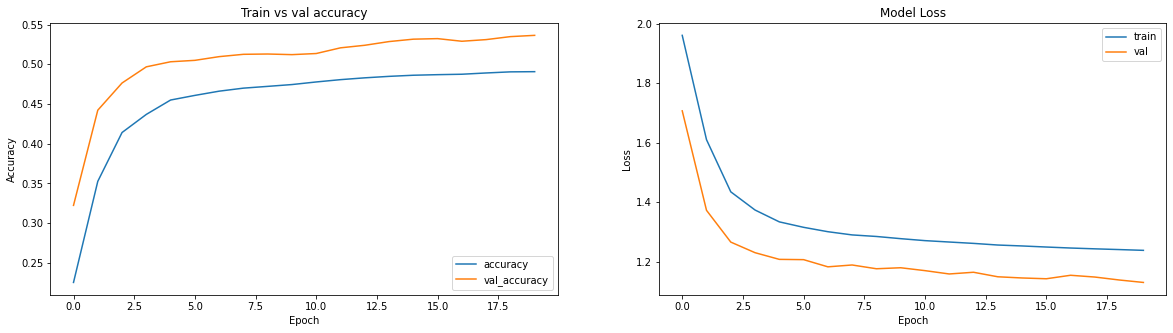

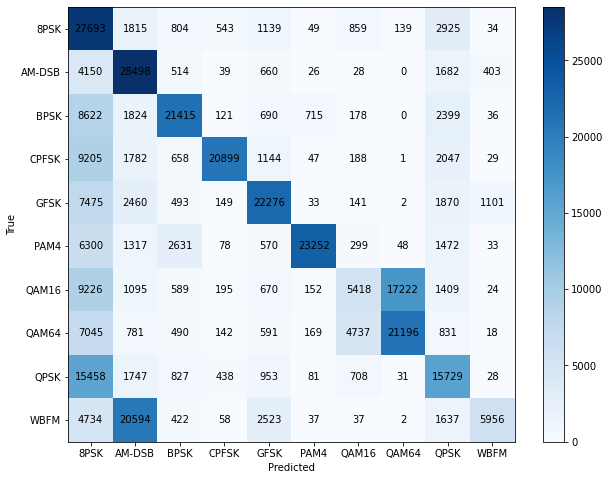

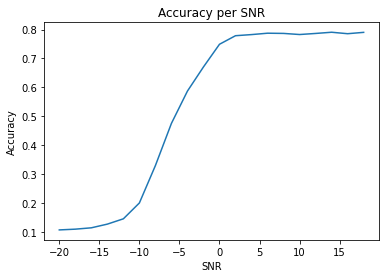

11250/11250 [==============================] - 30s 3ms/step - loss: 1.1331 - accuracy: 0.5343


In [55]:
test_acc, train_acc, val_acc = evaluate_model(CNNModel,history_cnn)

In [56]:
print_accuracies(test_acc, train_acc, val_acc)

Max Train accuracy =  0.4906177818775177
Max Val accuracy =  0.5363571643829346
Max Test accuracy =  0.5342555642127991


## Vanilla RNN Model

### Model

In [35]:
RNNModel = Sequential()
RNNModel.add(SimpleRNN(64, input_shape=list(x_train.shape[1:]), activation='relu'))
RNNModel.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
RNNModel.add(Dense(units=10, activation='softmax'))
RNNModel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
RNNModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 21,962
Trainable params: 21,962
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_rnn = RNNModel.fit(x_train, y_train[:,0], 
                           epochs=20, 
                           batch_size=1024, 
                           validation_data=(x_val, y_val[:,0]),
                           verbose=1, 
                           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')])


Epoch 1/20
780/780 - 5s - loss: 1.8724 - accuracy: 0.2611 - val_loss: 1.7020 - val_accuracy: 0.3164 - 5s/epoch - 6ms/step
Epoch 2/20
780/780 - 4s - loss: 1.6603 - accuracy: 0.3305 - val_loss: 1.6322 - val_accuracy: 0.3444 - 4s/epoch - 5ms/step
Epoch 3/20
780/780 - 3s - loss: 1.6090 - accuracy: 0.3497 - val_loss: 1.5986 - val_accuracy: 0.3534 - 3s/epoch - 4ms/step
Epoch 4/20
780/780 - 3s - loss: 1.5760 - accuracy: 0.3605 - val_loss: 1.5674 - val_accuracy: 0.3614 - 3s/epoch - 4ms/step
Epoch 5/20
780/780 - 3s - loss: 1.5530 - accuracy: 0.3681 - val_loss: 1.5528 - val_accuracy: 0.3669 - 3s/epoch - 4ms/step
Epoch 6/20
780/780 - 3s - loss: 1.5385 - accuracy: 0.3728 - val_loss: 1.5420 - val_accuracy: 0.3699 - 3s/epoch - 4ms/step
Epoch 7/20
780/780 - 5s - loss: 1.5276 - accuracy: 0.3766 - val_loss: 1.5318 - val_accuracy: 0.3760 - 5s/epoch - 7ms/step
Epoch 8/20
780/780 - 5s - loss: 1.5178 - accuracy: 0.3804 - val_loss: 1.5222 - val_accuracy: 0.3770 - 5s/epoch - 6ms/step
Epoch 9/20
780/780 - 5s 

### Evaluation

11250/11250 [==============================] - 25s 2ms/step


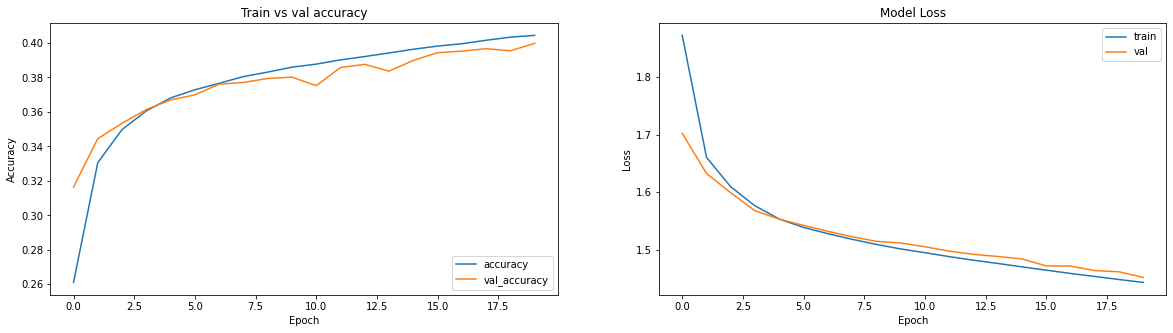

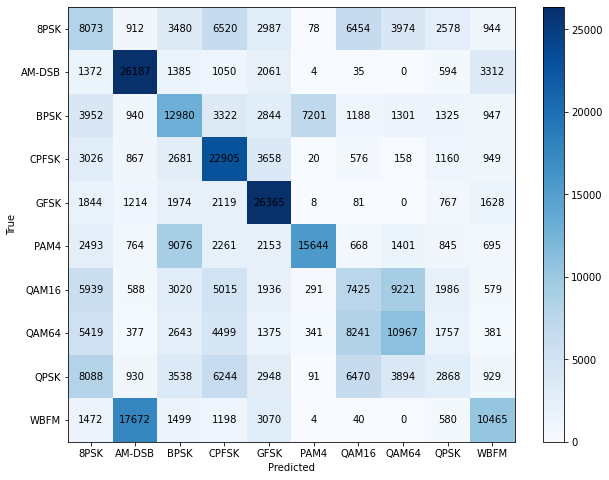

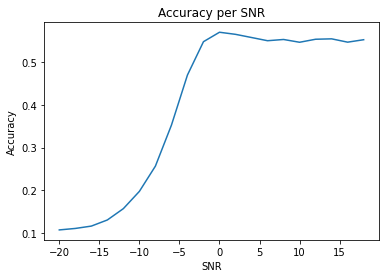

11250/11250 [==============================] - 30s 3ms/step - loss: 1.4496 - accuracy: 0.3997


In [50]:
test_acc, train_acc, val_acc = evaluate_model(RNNModel,history_rnn)

In [51]:
print_accuracies(test_acc, train_acc, val_acc)

Max Train accuracy =  0.404364675283432
Max Val accuracy =  0.3997381031513214
Max Test accuracy =  0.39966389536857605


## LSTM Model

### Model

In [59]:
LSTMModel = Sequential()
LSTMModel.add(LSTM(64, dropout = 0.3, return_sequences = True, recurrent_dropout = 0.3, input_shape = list(x_train.shape[1:])))
LSTMModel.add(Flatten())
LSTMModel.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
LSTMModel.add(Dense(10, activation = 'softmax'))
LSTMModel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTMModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 64)             49408     
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 67,210
Trainable params: 67,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = LSTMModel.fit(x_train, y_train[:,0], 
                                 epochs=20, batch_size=32, 
                                 validation_data=(x_val, y_val[:,0]),
                                 verbose=1, 
                                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')])


Epoch 1/20
 1883/24938 [=>............................] - ETA: 4:19 - loss: 2.0882 - accuracy: 0.1866

### Evaluation

In [ ]:
test_acc, train_acc, val_acc = evaluate_model(LSTMModel,history_lstm_raw)

In [ ]:
print_accuracies(test_acc, train_acc, val_acc)